# 2018 Mashine Learning course at the Faculty of Physics, Astronomy and Applied Computer Science

## Lab class no. 3 - Variable selection, Regularization and Principal Component Analysis
by Piotr Warchoł


This is an amalgamation of a couple opensource notebooks from the web, with some adjustments.

Today, we will do some variable selection and work throuhg a principal components analysis example.

In [1]:
# To support both python 2 and python 3
from __future__ import division, print_function, unicode_literals

# To plot pretty figures
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.cm as cmx
import matplotlib.colors as colors
plt.rcParams['axes.labelsize'] = 14
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12
plt.rcParams['figure.figsize']=12,10
import seaborn as sns

import itertools as it
import pandas as pd
import numpy as np
#import os

import warnings
warnings.filterwarnings('ignore')


from sklearn.linear_model import LinearRegression as Lin_Reg
from sklearn.linear_model import Ridge as Ridge_Reg
from sklearn.linear_model import Lasso as Lasso_Reg
from sklearn import cross_validation
#from statsmodels.regression.linear_model import OLS
import sklearn.preprocessing as Preprocessing

from sklearn.cross_validation import train_test_split
from sklearn.cross_validation import KFold
from sklearn.cross_validation import cross_val_score

import itertools as it
from itertools import combinations

import scipy as sp


# to make this notebook's output stable across runs
np.random.seed(42)

/usr/local/lib/python3.6/dist-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [2]:
%matplotlib inline

### Predictor selection, Lasso, Ridge Regressions

(This part of the notebook is based on solutions to a Harvard machine learning class by Tim Hagmann.)


First, lets look at some data and check if the predictors are correalted...

In [71]:
# Load data
data = np.loadtxt('./dataset_1.txt', delimiter=',', skiprows=1)

# Split predictors and response
x = data[:,:-1]
y = data[:, -1]

df = pd.DataFrame(data)
df.head()


,0,1,2,3,4,5,6,7,8,9,10
0,0.959357,0.959357,0.959357,0.343727,0.524083,0.537768,0.435598,0.831999,0.153247,0.005016,0.289394
1,0.616969,0.616969,0.616969,0.287376,0.513844,0.497775,0.452732,0.914609,0.367390,0.444473,-0.277574
2,0.995941,0.995941,0.995941,0.107294,0.097106,0.146751,0.136414,0.635926,0.535209,0.899457,-0.513097
3,0.821732,0.821732,0.821732,0.202558,0.329504,0.359471,0.281453,0.106263,0.479327,0.256271,-0.182353
4,0.302423,0.302423,0.302423,0.184564,0.270263,0.293385,0.263866,0.378630,0.740241,0.468589,-0.625117


In [5]:
# Compute matrix of correlation coefficients
corr_matrix = np.corrcoef(x.T)
pd.DataFrame(corr_matrix)

,0,1,2,3,4,5,6,7,8,9
0,1.000000,1.000000,1.000000,-0.189945,-0.232439,-0.215623,-0.228322,-0.047643,-0.061022,0.050977
1,1.000000,1.000000,1.000000,-0.189945,-0.232439,-0.215623,-0.228322,-0.047643,-0.061022,0.050977
2,1.000000,1.000000,1.000000,-0.189945,-0.232439,-0.215623,-0.228322,-0.047643,-0.061022,0.050977
3,-0.189945,-0.189945,-0.189945,1.000000,0.974279,0.964344,0.969540,0.058516,0.108294,-0.010416
4,-0.232439,-0.232439,-0.232439,0.974279,1.000000,0.982785,0.982227,0.080342,0.126004,-0.012399
5,-0.215623,-0.215623,-0.215623,0.964344,0.982785,1.000000,0.976308,0.079547,0.123368,-0.021029
6,-0.228322,-0.228322,-0.228322,0.969540,0.982227,0.976308,1.000000,0.074004,0.112241,-0.022023
7,-0.047643,-0.047643,-0.047643,0.058516,0.080342,0.079547,0.074004,1.000000,-0.133182,0.052151
8,-0.061022,-0.061022,-0.061022,0.108294,0.126004,0.123368,0.112241,-0.133182,1.000000,0.006923
9,0.050977,0.050977,0.050977,-0.010416,-0.012399,-0.021029,-0.022023,0.052151,0.006923,1.000000


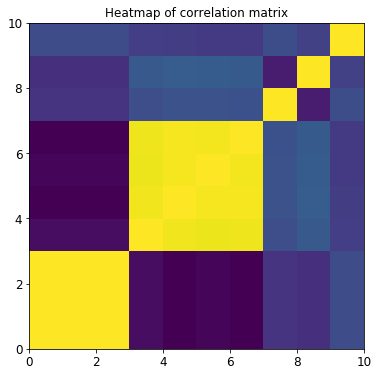

In [6]:
# Display heat map 
fig, ax = plt.subplots(1, 1, figsize=(6, 6))

ax.pcolor(corr_matrix)

ax.set_title('Heatmap of correlation matrix')

plt.show()

#### How many and, which predictors would you choose, to perform the regression? 


Lets look what the best subset selection algorithm will have to say about that

In [7]:
#from statsmodels.regression.linear_model import OLS

### Best Subset Selection
max_r2 = 0 # set some initial small value for max R^2 score
best_subset = [] # best subset of predictors

# Create all possible subsets of the set of 10 predictors
predictor_set = set(range(10)) # predictor set = {0, 1, 2, 3, 4, 5, 6, 7, 8, 9}

# Repeat for every possible size of subset
for size_k in range(10): 
    # Create all possible subsets of size 'size', 
    # using the 'combination' function from the 'itertools' library
    subsets_of_size_k = it.combinations(predictor_set, size_k + 1) 

    
    max_r_squared = -1e10 # set some initial small value for max R^2 score
    best_k_subset = [] # best subset of predictors of size k
    
     # Iterate over all subsets of our predictor set
    for predictor_subset in subsets_of_size_k:    
        #print(predictor_subset)
        # Use only a subset of predictors in the training data
        x_subset = x[:,predictor_subset]

        # Fit and evaluate R^2
        model = Lin_Reg()
        results = model.fit(x_subset,y)
        r_squared = model.score(x_subset,y)
        #print(r_squared)
        
        # Update max R^2 and best predictor subset of size k
        # If current predictor subset has a higher R^2 score than that of the best subset 
        # we've found so far, remember the current predictor subset as the best!
        if(r_squared > max_r_squared): 
            max_r_squared = r_squared
            best_k_subset = predictor_subset[:]
                

    # Use only the best subset of size k for the predictors
    x_subset = x[:, best_k_subset]
        
    # Fit and evaluate R^2 of the best subset of size k.
    model = Lin_Reg()
    results = model.fit(x_subset,y)
    r2= cross_validation.cross_val_score(model, x_subset, y, scoring='r2')
    r2=r2.mean()
    print(r2)
    
    # Update maximum r^2 and best predictor subset
    # If current predictor has a higher R^2 score than that of the best subset 
    # we've found so far, remember the current predictor as the best!
    if(r2 > max_r2): 
        max_r2 = r2
        best_subset = best_k_subset[:]
    
print('Best subset by exhaustive search:')
print(sorted(best_subset))

0.2911177732313952
0.4777247029076211
0.4989896021209932
0.5442716028653578
0.5478295777097153
0.5646618824626197
0.563937951880421
0.5595524223593852
0.5608437970969727
0.5475664891613562
Best subset by exhaustive search:
[0, 3, 5, 7, 8, 9]


Forward selection

In [8]:
### Step-wise Forward Selection
d = x.shape[1] # total no. of predictors

# Keep track of current set of chosen predictors, and the remaining set of predictors
current_predictors = [] 
remaining_predictors = list(range(d))

global_max_r2 = 0

# Keep track of the best subset of predictors
best_subset = [] 

# Iterate over all possible subset sizes, 0 predictors to d predictors
for size in range(d):    
    max_r_squared = -1e10 # set some initial small value for max R^2
    best_predictor = -1 # set some throwaway initial number for the best predictor to add
    max_r2=0   
        
    # Iterate over all remaining predictors to find best predictor to add
    for i in remaining_predictors:
        # Make copy of current set of predictors
        temp = current_predictors[:]
        # Add predictor 'i'
        temp.append(i)
                                    
        # Use only a subset of predictors in the training data
        x_subset = x[:, temp]
        
        # Fit and evaluate R^2
        model = Lin_Reg()
        results = model.fit(x_subset,y)
        r_squared = model.score(x_subset,y)
        
        # Check if we get a higher R^2 value than than current max R^2, if so, update
        if(r_squared > max_r_squared):
            max_r_squared = r_squared
            best_predictor = i
            r2= cross_validation.cross_val_score(model, x_subset, y, scoring='r2')
            r2=r2.mean()
            r2_with_best_predictor = r2
    
    # Remove best predictor from remaining list, and add best predictor to current list
    remaining_predictors.remove(best_predictor)
    current_predictors.append(best_predictor)
    
    # Check if r^2 for with the predictor we just added is higher than 
    # the global maximum across all subset of predictors
    if(r2_with_best_predictor > global_max_r2):
        best_subset = current_predictors[:]
        global_max_r2 = r2_with_best_predictor
    
print('Step-wise forward subset selection:')
print(sorted(best_subset)) # add 1 as indices start from 0

Step-wise forward subset selection:
[0, 3, 5, 7, 8, 9]


... and backward selection

In [9]:
###  Step-wise Backward Selection
d = x.shape[1] # total no. of predictors

# Keep track of current set of chosen predictors
current_predictors = list(range(d))

# First, fit and evaluate cross-validated R^2 using all 'd' number of predictors
model = Lin_Reg()
results = model.fit(x,y)
r2_all = cross_validation.cross_val_score(model, x, y, scoring='r2').mean()


# Set the maximum R^2 score, initially, to the R^2 score using all 'd' predictors
global_max_r2 = r2_all
# Keep track of the best subset of predictors
best_subset = [] 

# Iterate over all possible subset sizes, d predictors to 1 predictor
for size in range(d - 1, 1, -1): # stop before 0 to avoid choosing an empty set of predictors
    max_r_squared = -1e10 # set some initial small value for max R^2
    worst_predictor = -1 # set some throwaway initial number for the worst predictor to remove
    r2_without_worst_predictor = -0.2 # set some initial small value for max R^2 score  
        
    # Iterate over current set of predictors (for potential elimination)
    for i in current_predictors:
        # Create copy of current predictors, and remove predictor 'i'
        temp = current_predictors[:]
        temp.remove(i)
                                    
        # Use only a subset of predictors in the training data
        x_subset = x[:, temp]
        
        # Fit and evaluate R^2
        model = Lin_Reg()
        results = model.fit(x_subset,y)
        r_squared = model.score(x_subset,y)
        
        # Check if we get a higher R^2 value than than current max R^2, if so, update
        if(r_squared > max_r_squared):
            max_r_squared = r_squared
            worst_predictor = i
            r2= cross_validation.cross_val_score(model, x_subset, y, scoring='r2')
            r2=r2.mean()
            r2_without_worst_predictor = r2
          
    # Remove worst predictor from current set of predictors
    current_predictors.remove(worst_predictor)
    
    # Check if R^2 for the predictor we just removed is higher than 
    # the global maximum across all subset of predictors
    if(r2_without_worst_predictor > global_max_r2):
        best_subset = current_predictors[:]
        global_max_r2 = r2_without_worst_predictor
    
print('Step-wise backward subset selection:')
print(sorted(best_subset))

Step-wise backward subset selection:
[2, 3, 5, 7, 8, 9]


Lets look at what Lasso and ridge will do...

#### Play with the alpha parameter - this is lambda from the lecture. See what happens.

In [10]:
# Lasso regression
reg = Lasso_Reg(alpha = 0.01)
reg.fit(x, y)
coefficients = reg.coef_

print('Lasso:')
print('Coefficients:', coefficients)
print('Predictors with non-zero coefficients:', [i for i, item in enumerate(coefficients) if abs(item) > 0])

Lasso:
Coefficients: [ 2.71741712e-02  1.14873159e-16  0.00000000e+00 -0.00000000e+00
 -2.53280567e-02 -0.00000000e+00 -0.00000000e+00  4.39732115e-02
 -4.06121850e-01 -2.22604739e-01]
Predictors with non-zero coefficients: [0, 1, 4, 7, 8, 9]


In [11]:
# Ridge regression: Fit and evaluate 
reg = Ridge_Reg(alpha = 0.01)
x[:,1] = x[:,0]
x[:,2] = x[:,0]
reg.fit(x, y)
coefficients = reg.coef_

print('Ridge:')
print('Coefficients:', coefficients)
print('Predictors with non-zero coefficients:', [i for i, item in enumerate(coefficients) if abs(item) > 0])

Ridge:
Coefficients: [ 0.04353543  0.04353543  0.04353543  0.55217415 -0.19706852 -0.61421737
  0.30484213  0.18742866 -0.50083242 -0.35908145]
Predictors with non-zero coefficients: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]


Now, we will look at a different data set:

In [14]:
## Load data
data = pd.read_csv('./dataset_2.txt')
data.head()

,horsepower,highway-mpg,symboling,normalized-losses,make,fuel-type,aspiration,num-of-doors,body-style,drive-wheels,...,engine-type,num-of-cylinders,engine-size,fuel-system,bore,stroke,compression-ratio,peak-rpm,city-mpg,price
0,95.0,24.0,0.0,120.232558,peugot,gas,std,four,wagon,rwd,...,l,four,120.0,mpfi,3.46,2.19,8.4,5000.0,19.0,16695.0
1,116.0,30.0,2.0,134.000000,toyota,gas,std,two,hardtop,rwd,...,ohc,four,146.0,mpfi,3.62,3.50,9.3,4800.0,24.0,11199.0
2,121.0,28.0,0.0,188.000000,bmw,gas,std,two,sedan,rwd,...,ohc,six,164.0,mpfi,3.31,3.19,9.0,4250.0,21.0,20970.0
3,184.0,16.0,0.0,120.232558,mercedes-benz,gas,std,four,sedan,rwd,...,ohcv,eight,308.0,mpfi,3.80,3.35,8.0,4500.0,14.0,40960.0
4,111.0,29.0,0.0,102.000000,subaru,gas,turbo,four,sedan,4wd,...,ohcf,four,108.0,mpfi,3.62,2.64,7.7,4800.0,24.0,11259.0


In [15]:
# Split predictors and response
y = data.iloc[:, -1]
x = data.iloc[:, :-1]

## Transformations
# Transform symboling into categorical variable
x['symboling'] = x['symboling'].astype(object)

# Some of the predictors are categorical. Lets produce some dummy variables
categorical_bolean = (x.dtypes == "object").values
x_numeric = x.loc[:, ~categorical_bolean]
x_categorical = x.loc[:, categorical_bolean]
x_dummies = pd.get_dummies(x_categorical)

## Scale the numerical x variables
x_numeric = x_numeric / x_numeric.std(axis=0)

## Bind data together
x = pd.concat([x_numeric, x_dummies], axis=1)
print(x.shape)

(205, 69)


In [16]:
## Split the dataset
np.random.seed(856) # Set seed
x_train, x_test = train_test_split(x, test_size = 0.25)

## Split the variables
y_train = y.iloc[x_train.index.values]
y_test = y.iloc[x_test.index.values]
x_train = x.iloc[x_train.index.values, :]
x_test = x.iloc[x_test.index.values, :]

## Transform to numpy 
y_train = y_train.values
y_test = y_test.values
x_train = x_train.values
x_test = x_test.values

In [17]:
# First, let's do plain OLS
reg = Lin_Reg()
reg.fit(x_train, y_train)

train_r_squared_plain = reg.score(x_train, y_train)
test_r_squared_plain = reg.score(x_test, y_test)

print('Plain Regression: R^2 score on training set', train_r_squared_plain)
print('Plain Regression: R^2 score on test set', test_r_squared_plain)

Plain Regression: R^2 score on training set 0.9909551953968768
Plain Regression: R^2 score on test set 0.9580591634394


The linear regression overfits a bit. Now, we will look how the Ridge regression will deal with that.

In [18]:
# Ridge regression: Fit and evaluate 
reg = Ridge_Reg(alpha = 1.0)
reg.fit(x_train, y_train)
coefficients = reg.coef_

predictors = [i for i, item in enumerate(coefficients) if abs(item) > 0]

print('Ridge:')
print('Coefficients:', coefficients)
print('Selected predictors:',predictors)
print('Ridge Regression: R^2 score on training set', reg.score(x_train,y_train))
print('Ridge Regression: R^2 score on test set', reg.score(x_test,y_test))

Ridge:
Coefficients: [  992.92148619   553.97771546   444.35687821  -828.94054753
  -525.36834772  2211.93526343   459.23600141  1160.12392818
  4443.04676286 -1125.6272756  -1718.78978862   315.37876754
   344.79954543  -758.59928852  -924.65800278   -36.75443242
   457.93905479  1014.82987063  -630.91902486   119.56253464
   395.33569594  2884.31772629    77.27639028 -1644.3110965
    13.51645961  -704.2174629   3183.18495578 -1863.20872571
 -1458.68909567  -836.10191045  -667.66261737 -1441.07097977
  2494.76231488   567.89881667  1449.1084432  -2179.99901015
  -893.98887089  -364.09680086   987.94576763    71.98632035
   -71.98632035  -905.22298642   905.22298642   181.93047182
  -181.93047182  2266.97626872   459.87867544  -736.78619848
  -871.37469    -1118.69405569    37.65252076    17.84309103
   -55.49561178 -2998.30613842  2998.30613842    77.68045447
  -667.66261737  1229.61288637   818.30712827 -1457.93785174
  2794.18813447  -659.19799568  -128.44268015 -2006.54745864
    

In [19]:
# Run for different values of lambda 
lambda_min = -7
lambda_max = 7

num_lambdas = 15
num_predictors = x.shape[1]

lambdas= np.linspace(lambda_min,lambda_max, num_lambdas)

train_r_squared = np.zeros(num_lambdas)
test_r_squared = np.zeros(num_lambdas)

coeff_a = np.zeros((num_lambdas, num_predictors))

In [20]:
for ind, i in enumerate(lambdas):    
    # Fit ridge regression on train set
    reg = Ridge_Reg(alpha = 10**i)
    reg.fit(x_train, y_train)
       
    coeff_a[ind,:] = reg.coef_
    # Evaluate train & test performance
    train_r_squared[ind] = reg.score(x_train, y_train)
    test_r_squared[ind] = reg.score(x_test, y_test)

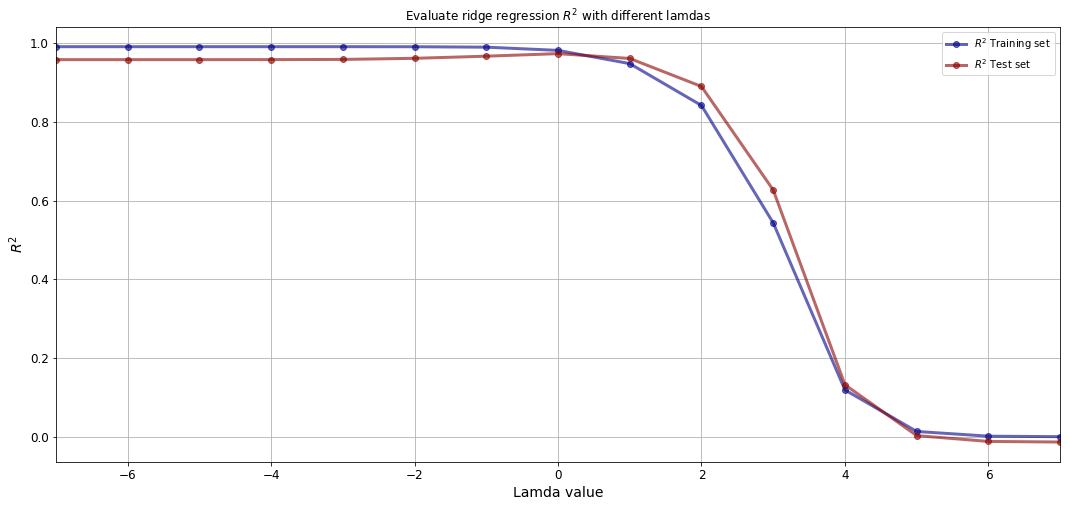

In [21]:
# Plotting
plt.figure(figsize=(18, 8))
plt.plot(lambdas, train_r_squared, 'bo-', label=r'$R^2$ Training set', color="darkblue", alpha=0.6, linewidth=3)
plt.plot(lambdas, test_r_squared, 'bo-', label=r'$R^2$ Test set', color="darkred", alpha=0.6, linewidth=3)
plt.xlabel('Lamda value'); plt.ylabel(r'$R^2$')
plt.xlim(lambda_min, lambda_max)
plt.title(r'Evaluate ridge regression $R^2$ with different lamdas')
plt.legend(loc='best')
plt.grid()

#### What is the lambda value for which the R^2 is highest? What does this mean?


Lets do the same with cross-validation

In [22]:
# Run for different values of lambda 
lambda_min = -7
lambda_max = 7

num_lambdas = 15
num_predictors = x.shape[1]

lambdas= np.linspace(lambda_min,lambda_max, num_lambdas)

train_r_squared = np.zeros(num_lambdas)
test_r_squared = np.zeros(num_lambdas)

In [23]:
kfold = KFold(n=len(x), n_folds=5, random_state=123)

for ind, i in enumerate(lambdas):    
    # Fit ridge regression on train set
    reg = Ridge_Reg(alpha = 10**i)
    reg.fit(x_train, y_train)
    results = cross_val_score(reg, x, y, cv=kfold, scoring="r2")
   
    # Evaluate train & test performance
    train_r_squared[ind] = results.mean()
    test_r_squared[ind] = reg.score(x_test, y_test)

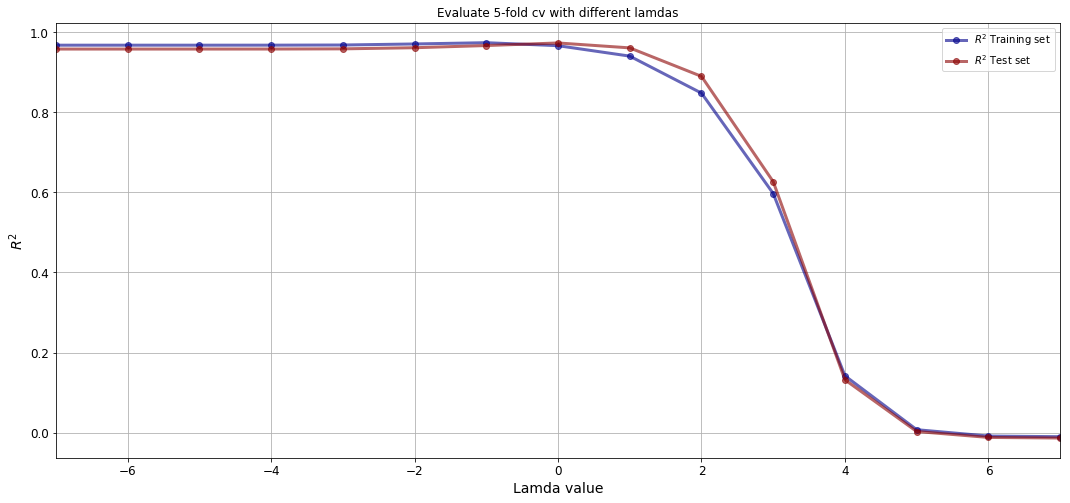

In [24]:
# Plotting
plt.figure(figsize=(18, 8))
plt.plot(lambdas,train_r_squared, 'bo-', label=r'$R^2$ Training set', color="darkblue", alpha=0.6, linewidth=3)
plt.plot(lambdas, test_r_squared, 'bo-', label=r'$R^2$ Test set', color="darkred", alpha=0.6, linewidth=3)
plt.xlabel('Lamda value'); plt.ylabel(r'$R^2$')
plt.xlim(lambda_min, lambda_max)
plt.title(r'Evaluate 5-fold cv with different lamdas')
plt.legend(loc='best')
plt.grid()

## Principal Component Analysis


Principal Component Analysis (PCA) is a simple yet popular and useful linear transformation technique that is used in numerous applications, such as stock market predictions, the  analysis of gene expression data, and many more. In this tutorial, we will see that PCA is not just a "black box", and we are going to unravel its internals in 3 basic steps.

the notebook is a slightly modified version from https://sebastianraschka.com/notebooks/ml-notebooks.html

### Introduxtion

The sheer size of data in the modern age is not only a challenge for computer hardware but also a main bottleneck for the performance of many machine learning algorithms. The main goal of a PCA analysis is to identify patterns in data; PCA aims to detect the correlation between variables. If a strong correlation between variables exists, the attempt to reduce the dimensionality only makes sense. In a nutshell, this is what PCA is all about: Finding the directions of maximum variance in high-dimensional data and project it onto a smaller dimensional subspace while retaining most of the information.


Often, the desired goal is to reduce the dimensions of a $d$-dimensional dataset by projecting it onto a $(k)$-dimensional subspace (where $k\;<\;d$) in order to increase the computational efficiency while retaining most of the information. An important question is "what is the size of $k$ that represents the data 'well'?"

Later, we will compute eigenvectors (the principal components) of a dataset and collect them in a projection matrix. Each of those eigenvectors is associated with an eigenvalue which can be interpreted as the "length" or "magnitude" of the corresponding eigenvector. If some eigenvalues have a significantly larger magnitude than others that the reduction of the dataset via PCA onto a smaller dimensional subspace by dropping the "less informative" eigenpairs is reasonable.


#### PCS approach

-  Standardize the data.
-  Obtain the Eigenvectors and Eigenvalues from the covariance matrix or correlation matrix, or perform Singular Vector Decomposition.
-  Sort eigenvalues in descending order and choose the $k$ eigenvectors that correspond to the $k$ largest eigenvalues where $k$ is the number of dimensions of the new feature subspace ($k \le d$)/.
-  Construct the projection matrix $\mathbf{W}$ from the selected $k$ eigenvectors.
-  Transform the original dataset $\mathbf{X}$ via $\mathbf{W}$ to obtain a $k$-dimensional feature subspace $\mathbf{Y}$.


#### We will work with the famous Iris dataset

For the following tutorial, we will be working with the famous "Iris" dataset that has been deposited on the UCI machine learning repository   
([https://archive.ics.uci.edu/ml/datasets/Iris](https://archive.ics.uci.edu/ml/datasets/Iris)).

The iris dataset contains measurements for 150 iris flowers from three different species.

The three classes in the Iris dataset are:

1. Iris-setosa (n=50)
2. Iris-versicolor (n=50)
3. Iris-virginica (n=50)

And the four features of in Iris dataset are:

1. sepal length in cm
2. sepal width in cm
3. petal length in cm
4. petal width in cm

See an Iris here http://5047-presscdn.pagely.netdna-cdn.com/wp-content/uploads/2015/04/iris_petal_sepal.png


In [25]:
df = pd.read_csv(
    filepath_or_buffer='https://archive.ics.uci.edu/ml/machine-learning-databases/iris/iris.data', 
    header=None, 
    sep=',')

df.columns=['sepal_len', 'sepal_wid', 'petal_len', 'petal_wid', 'class']
df.dropna(how="all", inplace=True) # drops the empty line at file-end

df.tail()

,sepal_len,sepal_wid,petal_len,petal_wid,class
145,6.7,3.0,5.2,2.3,Iris-virginica
146,6.3,2.5,5.0,1.9,Iris-virginica
147,6.5,3.0,5.2,2.0,Iris-virginica
148,6.2,3.4,5.4,2.3,Iris-virginica
149,5.9,3.0,5.1,1.8,Iris-virginica


In [26]:
# split data table into data X and class labels y

X = df.ix[:,0:4].values
y = df.ix[:,4].values

Our iris dataset is now stored in form of a  $150 \times 4$ matrix where the columns are the different features, and every row represents a separate flower sample.
Each sample row $\mathbf{x}$ can be pictured as a 4-dimensional vector   


$\mathbf{x^T} = \begin{pmatrix} x_1 \\ x_2 \\ x_3 \\ x_4 \end{pmatrix} 
= \begin{pmatrix} \text{sepal length} \\ \text{sepal width} \\\text{petal length} \\ \text{petal width} \end{pmatrix}$

To get a feeling for how the 3 different flower classes are distributes along the 4 different features, let us visualize them via histograms.

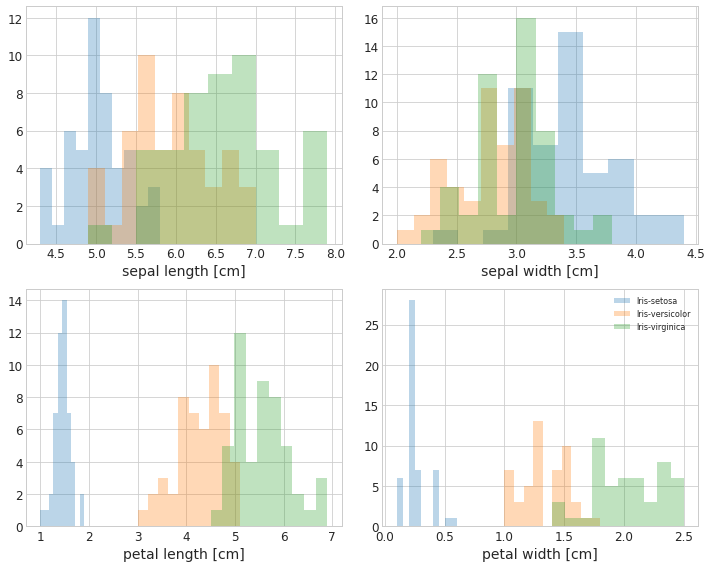

In [27]:
import math

label_dict = {1: 'Iris-Setosa',
              2: 'Iris-Versicolor',
              3: 'Iris-Virgnica'}

feature_dict = {0: 'sepal length [cm]',
                1: 'sepal width [cm]',
                2: 'petal length [cm]',
                3: 'petal width [cm]'}

with plt.style.context('seaborn-whitegrid'):
    plt.figure(figsize=(10, 8))
    for cnt in range(4):
        plt.subplot(2, 2, cnt+1)
        for lab in ('Iris-setosa', 'Iris-versicolor', 'Iris-virginica'):
            plt.hist(X[y==lab, cnt],
                     label=lab,
                     bins=10,
                     alpha=0.3,)
        plt.xlabel(feature_dict[cnt])
    plt.legend(loc='upper right', fancybox=True, fontsize=8)

    plt.tight_layout()
    plt.show()

#### Standarization

Whether to standardize the data prior to a PCA on the covariance matrix depends on the measurement scales of the original features. Since PCA yields a feature subspace that maximizes the variance along the axes, it makes sense to standardize the data, especially, if it was measured on different scales. Although, all features in the Iris dataset were measured in centimeters, let us continue with the transformation of the data onto unit scale (mean=0 and variance=1), which is a requirement for the optimal performance of many machine learning algorithms.

In [28]:
from sklearn.preprocessing import StandardScaler
X_std = StandardScaler().fit_transform(X)

#### Eigendecomposition - Computing Eigenvectors and Eigenvalues

The eigenvectors and eigenvalues of a covariance (or correlation) matrix represent the "core" of a PCA: The eigenvectors (principal components) determine the directions of the new feature space, and the eigenvalues determine their magnitude. In other words, the eigenvalues explain the variance of the data along the new feature axes.

#### Covariance Matrix

The classic approach to PCA is to perform the eigendecomposition on the covariance matrix $\Sigma$, which is a $d \times d$ matrix where each element represents the covariance between two features. The covariance between two features is calculated as follows:

$\sigma_{jk} = \frac{1}{n-1}\sum_{i=1}^{N}\left(  x_{ij}-\bar{x}_j \right)  \left( x_{ik}-\bar{x}_k \right).$

We can summarize the calculation of the covariance matrix via the following matrix equation:   
$\Sigma = \frac{1}{n-1} \left( (\mathbf{X} - \mathbf{\bar{x}})^T\;(\mathbf{X} - \mathbf{\bar{x}}) \right)$  
where $\mathbf{\bar{x}}$ is the mean vector 
$\mathbf{\bar{x}} = \sum\limits_{i=1}^n x_{i}.$  
The mean vector is a $d$-dimensional vector where each value in this vector represents the sample mean of a feature column in the dataset.

In [29]:
mean_vec = np.mean(X_std, axis=0)
cov_mat = (X_std - mean_vec).T.dot((X_std - mean_vec)) / (X_std.shape[0]-1)
print('Covariance matrix \n%s' %cov_mat)

Covariance matrix 
[[ 1.00671141 -0.11010327  0.87760486  0.82344326]
 [-0.11010327  1.00671141 -0.42333835 -0.358937  ]
 [ 0.87760486 -0.42333835  1.00671141  0.96921855]
 [ 0.82344326 -0.358937    0.96921855  1.00671141]]


The more verbose way above was simply used for demonstration purposes, equivalently, we could have used the numpy `cov` function:

In [30]:
print('NumPy covariance matrix: \n%s' %np.cov(X_std.T))

NumPy covariance matrix: 
[[ 1.00671141 -0.11010327  0.87760486  0.82344326]
 [-0.11010327  1.00671141 -0.42333835 -0.358937  ]
 [ 0.87760486 -0.42333835  1.00671141  0.96921855]
 [ 0.82344326 -0.358937    0.96921855  1.00671141]]


Next, we perform an eigendecomposition on the covariance matrix:

In [31]:
cov_mat = np.cov(X_std.T)

eig_vals, eig_vecs = np.linalg.eig(cov_mat)

print('Eigenvectors \n%s' %eig_vecs)
print('\nEigenvalues \n%s' %eig_vals)

Eigenvectors 
[[ 0.52237162 -0.37231836 -0.72101681  0.26199559]
 [-0.26335492 -0.92555649  0.24203288 -0.12413481]
 [ 0.58125401 -0.02109478  0.14089226 -0.80115427]
 [ 0.56561105 -0.06541577  0.6338014   0.52354627]]

Eigenvalues 
[2.93035378 0.92740362 0.14834223 0.02074601]


#### Correlation matrix

Especially, in the field of "Finance," the correlation matrix typically used instead of the covariance matrix. However, the eigendecomposition of the covariance matrix (if the input data was standardized) yields the same results as a eigendecomposition on the correlation matrix, since the correlation matrix can be understood as the normalized covariance matrix.


Eigendecomposition of the standardized data based on the correlation matrix:

In [32]:
cor_mat1 = np.corrcoef(X_std.T)

eig_vals, eig_vecs = np.linalg.eig(cor_mat1)

print('Eigenvectors \n%s' %eig_vecs)
print('\nEigenvalues \n%s' %eig_vals)

Eigenvectors 
[[ 0.52237162 -0.37231836 -0.72101681  0.26199559]
 [-0.26335492 -0.92555649  0.24203288 -0.12413481]
 [ 0.58125401 -0.02109478  0.14089226 -0.80115427]
 [ 0.56561105 -0.06541577  0.6338014   0.52354627]]

Eigenvalues 
[2.91081808 0.92122093 0.14735328 0.02060771]


Eigendecomposition of the raw data based on the correlation matrix:

In [33]:
cor_mat2 = np.corrcoef(X.T)

eig_vals, eig_vecs = np.linalg.eig(cor_mat2)

print('Eigenvectors \n%s' %eig_vecs)
print('\nEigenvalues \n%s' %eig_vals)

Eigenvectors 
[[ 0.52237162 -0.37231836 -0.72101681  0.26199559]
 [-0.26335492 -0.92555649  0.24203288 -0.12413481]
 [ 0.58125401 -0.02109478  0.14089226 -0.80115427]
 [ 0.56561105 -0.06541577  0.6338014   0.52354627]]

Eigenvalues 
[2.91081808 0.92122093 0.14735328 0.02060771]


We can clearly see that all three approaches yield the same eigenvectors and eigenvalue pairs:
    
- Eigendecomposition of the covariance matrix after standardizing the data.
- Eigendecomposition of the correlation matrix.
- Eigendecomposition of the correlation matrix after standardizing the data.


#### Singular Vector Decomposition


While the eigendecomposition of the covariance or correlation matrix may be more intuitiuve, most PCA implementations perform a Singular Vector Decomposition (SVD) to improve the computational efficiency. So, let us perform an SVD to confirm that the result are indeed the same:

In [34]:
u,s,v = np.linalg.svd(X_std.T)
print('Vectors U:\n', u)

Vectors U:
 [[-0.52237162 -0.37231836  0.72101681  0.26199559]
 [ 0.26335492 -0.92555649 -0.24203288 -0.12413481]
 [-0.58125401 -0.02109478 -0.14089226 -0.80115427]
 [-0.56561105 -0.06541577 -0.6338014   0.52354627]]


#### Sorting Eigenpairs

The typical goal of a PCA is to reduce the dimensionality of the original feature space by projecting it onto a smaller subspace, where the eigenvectors will form the axes. However, the eigenvectors only define the directions of the new axis, since they have all the same unit length 1, which can confirmed by the following two lines of code:

In [35]:
for ev in eig_vecs:
    np.testing.assert_array_almost_equal(1.0, np.linalg.norm(ev))
print('Everything ok!')

Everything ok!


In order to decide which eigenvector(s) can dropped without losing too much information
for the construction of lower-dimensional subspace, we need to inspect the corresponding eigenvalues: The eigenvectors with the lowest eigenvalues bear the least information about the distribution of the data; those are the ones can be dropped.  
In order to do so, the common approach is to rank the eigenvalues from highest to lowest in order choose the top $k$ eigenvectors.

In [36]:
# Make a list of (eigenvalue, eigenvector) tuples
eig_pairs = [(np.abs(eig_vals[i]), eig_vecs[:,i]) for i in range(len(eig_vals))]

# Sort the (eigenvalue, eigenvector) tuples from high to low
eig_pairs.sort(key=lambda x: x[0], reverse=True)

# Visually confirm that the list is correctly sorted by decreasing eigenvalues
print('Eigenvalues in descending order:')
for i in eig_pairs:
    print(i[0])

Eigenvalues in descending order:
2.9108180837520528
0.9212209307072254
0.1473532783050958
0.020607707235624842


#### Explained Variance

After sorting the eigenpairs, the next question is "how many principal components are we going to choose for our new feature subspace?" A useful measure is the so-called "explained variance," which can be calculated from the eigenvalues. The explained variance tells us how much information (variance) can be attributed to each of the principal components.

In [37]:
tot = sum(eig_vals)
var_exp = [(i / tot)*100 for i in sorted(eig_vals, reverse=True)]
cum_var_exp = np.cumsum(var_exp)

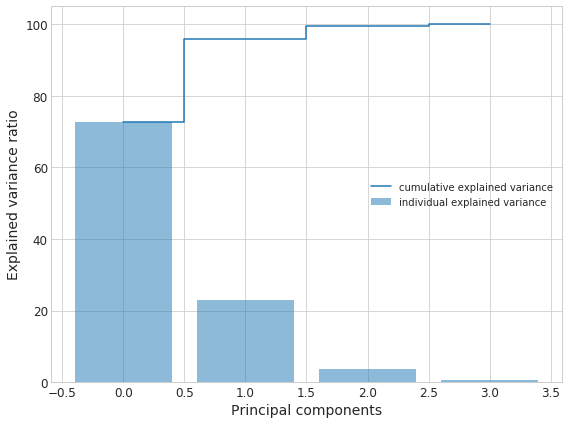

In [38]:
with plt.style.context('seaborn-whitegrid'):
    plt.figure(figsize=(8, 6))

    plt.bar(range(4), var_exp, alpha=0.5, align='center',
            label='individual explained variance')
    plt.step(range(4), cum_var_exp, where='mid',
             label='cumulative explained variance')
    plt.ylabel('Explained variance ratio')
    plt.xlabel('Principal components')
    plt.legend(loc='best')
    plt.tight_layout()


The plot above clearly shows that most of the variance (72.77% of the variance to be precise) can be explained by the first principal component alone. The second principal component still bears some information (23.03%) while the third and fourth principal components can safely be dropped without losing to much information. Together, the first two principal components contain 95.8% of the information.



#### Projection matrix

It's about time to get to the really interesting part: The construction of the projection matrix that will be used to transform the Iris data onto the new feature subspace. Although, the name "projection matrix" has a nice ring to it, it is basically just a matrix of our concatenated top *k* eigenvectors.

Here, we are reducing the 4-dimensional feature space to a 2-dimensional feature subspace, by choosing the "top 2" eigenvectors with the highest eigenvalues to construct our $d \times k$-dimensional eigenvector matrix $\mathbf{W}$.

In [39]:
matrix_w = np.hstack((eig_pairs[0][1].reshape(4,1), 
                      eig_pairs[1][1].reshape(4,1)))

print('Matrix W:\n', matrix_w)

Matrix W:
 [[ 0.52237162 -0.37231836]
 [-0.26335492 -0.92555649]
 [ 0.58125401 -0.02109478]
 [ 0.56561105 -0.06541577]]


#### Projecting on to the new feature space


In this last step we will use the $4 \times 2$-dimensional projection matrix $\mathbf{W}$ to transform our samples onto the new subspace via the equation  
$\mathbf{Y} = \mathbf{X} \times  \mathbf{W}$, where $\mathbf{Y}$ is a $150\times 2$ matrix of our transformed samples.

In [40]:
Y = X_std.dot(matrix_w)

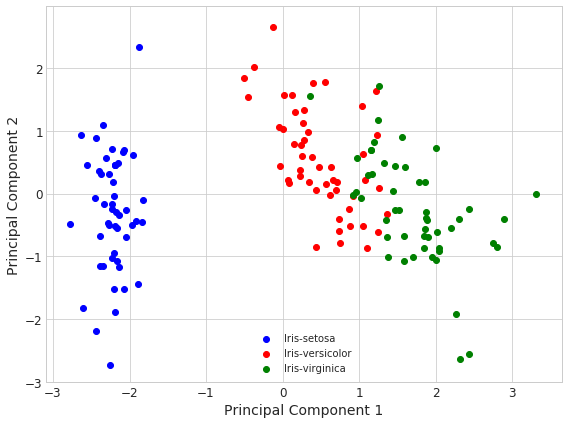

In [41]:
with plt.style.context('seaborn-whitegrid'):
    plt.figure(figsize=(8, 6))
    for lab, col in zip(('Iris-setosa', 'Iris-versicolor', 'Iris-virginica'), 
                        ('blue', 'red', 'green')):
        plt.scatter(Y[y==lab, 0],
                    Y[y==lab, 1],
                    label=lab,
                    c=col)
    plt.xlabel('Principal Component 1')
    plt.ylabel('Principal Component 2')
    plt.legend(loc='lower center')
    plt.tight_layout()

#### PCA with scikit-learn

For educational purposes, we went a long way to apply the PCA to the Iris dataset. But luckily, there is already implementation in scikit-learn. 

In [42]:
from sklearn.decomposition import PCA as sklearnPCA
sklearn_pca = sklearnPCA(n_components=2)
Y_sklearn = sklearn_pca.fit_transform(X_std)

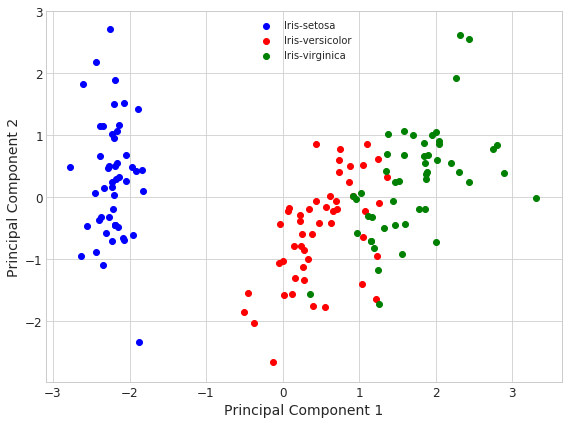

In [43]:
with plt.style.context('seaborn-whitegrid'):
    plt.figure(figsize=(8, 6))
    for lab, col in zip(('Iris-setosa', 'Iris-versicolor', 'Iris-virginica'), 
                        ('blue', 'red', 'green')):
        plt.scatter(Y_sklearn[y==lab, 0],
                    Y_sklearn[y==lab, 1],
                    label=lab,
                    c=col)
    plt.xlabel('Principal Component 1')
    plt.ylabel('Principal Component 2')
    plt.legend(loc='upper center')
    plt.tight_layout()
    plt.show()

# Homework 3

- Implement the ridge regression algorithm through a gradient descent algorithm
- apply it to a regression problem (with at least 10 predictors) for a chosen dataset
- optimize the choice of lambda with R^2 and cross-validation 
- check the accuracy of the final prediction on the test part of the data set.
- compare to a result of a simple linear regression fit
- comment on the results